### Exercise: energy consumption in building vs outside air temperature
The data provided in `buildingoat.csv` uses a dataset to model the Power of a building using the Outdoor Air Temperature (OAT) as an explanatory variable.  The **power** (Dutch: Vermogen), expressed in Watt (W),  of a building is a measure for the instantaneous energy comsumption.  Compare it to a light bulb of 10 W: if it is used for one hour it consumes 10 Wh (or 0.01 kWh) of electricity. On your electrity bill you are charged per kWh. Similarly, the power of a building in this exercise determines the energy consumption for heating.  A power of 160 kW (at a given outside temperature and a required inside temperature, which may vary during the day and week) means the building "looses" 160 kWh of heat energy per hour, which has to be provided by the heating installation to ensure a constant inside temperature.

Setup Python and the most common libraries

In [2]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Import buildingoat.csv from https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/buildingoat.csv. Show the first 5 records

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/buildingoat.csv')
data.head()

,Timestamp,OAT (F),Power (kW)
0,1/1/2010 1:15,51,165.1
1,1/1/2010 1:30,51,151.6
2,1/1/2010 1:45,51,146.9
3,1/1/2010 2:00,51,153.7
4,1/1/2010 2:15,51,153.8


What are the instances? Explain in "business terms"!  
What are the features? 

Explore the datatypes and non-null values per column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34940 entries, 0 to 34939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Timestamp   34940 non-null  object 
 1   OAT (F)     34940 non-null  int64  
 2   Power (kW)  34940 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 819.0+ KB


The temperature is expressed in degrees Fahrenheit (°F), which is used in the US. We can convert Fahrenheit to Celcius using the formula 

$°C = \frac{°F - 32}{1.8}$

Convert all values °F to °C. 

       Timestamp  OAT (F)  Power (kW)    OAT (C)
0  1/1/2010 1:15       51       165.1  10.555556
1  1/1/2010 1:30       51       151.6  10.555556
2  1/1/2010 1:45       51       146.9  10.555556
3  1/1/2010 2:00       51       153.7  10.555556
4  1/1/2010 2:15       51       153.8  10.555556
5  1/1/2010 2:30       51       159.0  10.555556
6  1/1/2010 2:45       51       157.7  10.555556
7  1/1/2010 3:00       51       163.2  10.555556
8  1/1/2010 3:15       50       151.7  10.000000
9  1/1/2010 3:30       50       148.7  10.000000


Convert the type of Timestamp from 'object' to 'datetime'. This will change the visualized format of Timestamp

,Timestamp,Power (kW),OAT (C)
0,2010-01-01 01:15:00,165.1,10.555556
1,2010-01-01 01:30:00,151.6,10.555556
2,2010-01-01 01:45:00,146.9,10.555556
3,2010-01-01 02:00:00,153.7,10.555556
4,2010-01-01 02:15:00,153.8,10.555556


Give the dimensions of the dataset

(34940, 3)

Give the statistics of the dataset

,Power (kW),OAT (C)
count,34940.000000,34940.000000
mean,261.644659,14.769828
std,65.673392,4.855195
min,0.000000,0.555556
25%,194.600000,11.666667
50%,276.700000,14.444444
75%,312.300000,17.777778
max,457.900000,37.777778


You can see that the mean value of Power (kW) is 261.644659 and the standard deviation 65.673392.  
Assign both values to a variable.  

261.64465941614196
65.67339168302733


Let's do some data cleaning by removing outliers according to the 68-95-99.7 - rule: drop all values that are more than 3 standard deviations from the mean
This is a popular way of removing outliers from the dataset, which are often bad registrations. 

,Timestamp,Power (kW),OAT (C)
0,2010-01-01 01:15:00,165.1,10.555556
1,2010-01-01 01:30:00,151.6,10.555556
2,2010-01-01 01:45:00,146.9,10.555556
3,2010-01-01 02:00:00,153.7,10.555556
4,2010-01-01 02:15:00,153.8,10.555556
...,...,...,...
34935,2010-12-30 23:00:00,285.8,8.333333
34936,2010-12-30 23:15:00,206.6,6.666667
34937,2010-12-30 23:30:00,205.9,6.666667
34938,2010-12-30 23:45:00,189.4,6.666667


You can guess there is a dependancy between the power consumption and the outside temperature.  
Plot the Power (kW) versus the OAT (C). Add parameter `kind='scatter'` to the plot function to obtain a scatter plot. 

<AxesSubplot:xlabel='OAT (C)', ylabel='Power (kW)'>

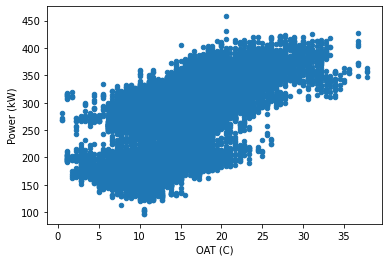

The Power is probably also highly dependent on the month of the year, the day of the week and the time of the day.  
We will use this information to incorporate into our regression model.  
Add extra columns for the month, day of the week and hour of the day, all as integer values. 

,Timestamp,Power (kW),OAT (C),Month,Day,Hour
34920,2010-12-30 19:15:00,326.3,8.888889,12,3,19
34921,2010-12-30 19:30:00,318.5,8.888889,12,3,19
34922,2010-12-30 19:45:00,316.9,8.888889,12,3,19
34923,2010-12-30 20:00:00,189.0,8.888889,12,3,20
34924,2010-12-30 20:15:00,280.8,8.888889,12,3,20
34925,2010-12-30 20:30:00,304.4,8.888889,12,3,20
34926,2010-12-30 20:45:00,306.8,8.888889,12,3,20
34927,2010-12-30 21:00:00,310.6,8.888889,12,3,21
34928,2010-12-30 21:15:00,309.4,8.333333,12,3,21
34929,2010-12-30 21:30:00,301.0,8.333333,12,3,21


Plot the histogram of the numerical attributes

The column Timestamp is of no use in our model, so drop it. 

Altough Month, Day and Hour are numeric, they are in fact categorical attributes, so apply one hot encoding; If you don't care about Pipelines (which is here the case, you can use Pandas' `get_dummies()` function iso Numpy's `OneHotEncoder()`. See https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html for the documentation about `get_dummies()`. 

,Power (kW),OAT (C),Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,165.1,10.555556,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,151.6,10.555556,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,146.9,10.555556,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,153.7,10.555556,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,153.8,10.555556,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34935,285.8,8.333333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34936,206.6,6.666667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34937,205.9,6.666667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34938,189.4,6.666667,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Use RandomForestRegressor to predict the Power (kW).  
Find the optimal number of trees based on RMSE. Choose between 3, 10, 30 and 50, take default values for the other features.  
Use cross validation with 3 folds.  
First put aside a randomized test set. Since we don't have a skew dataset stratified sampling is not really necessary. 

(27930, 45)
(6983, 45)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'n_estimators': [3, 10, 30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

{'n_estimators': 50}

RandomForestRegressor(n_estimators=50, random_state=42)

Evaluate Your System on the Test Set

18.475473931940897

Use your model to predict the first 5 lines of the training set and compare it to the "real" values

,OAT (C),Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
21118,16.111111,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
25015,23.333333,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
10424,21.111111,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
31671,7.222222,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24488,15.000000,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Predictions: [194.21836667 376.66075714 316.01535238 224.83052619 210.87165238]


Real values
 21118    188.5
25015    370.1
10424    310.0
31671    296.2
24488    200.9
Name: Power (kW), dtype: float64


Explain the concept of noise in this context